In [46]:
import bs4
from pyspark import SparkContext
import pymongo
import jieba
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
print "載入完成"

/usr/local/python/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


載入完成


參考資料http://hhtucode.blogspot.tw/2013/10/python-ml-with-scikit-learn-model.html

資料維度分析

In [41]:
from sklearn.datasets import load_digits #sklearn內建的資料庫
digits = load_digits()
X,y = digits.data, digits.target #X是帶有答案(標籤,或特徵)的資料; y只有data

print("data shape: %r, target shape: %r" % (X.shape, y.shape))
# numpy.array.shape為列出此array是幾行幾列的陣列

print("classes: %r" % list(np.unique(y)))

n_samples, n_features = X.shape 
#樣本數1797,每個樣本有64個標籤label(或稱作特徵feature)

data shape: (1797, 64), target shape: (1797,)
classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [57]:
from sklearn.decomposition import RandomizedPCA   #PCA(principal components analiysis)主成份分析降維
pca = RandomizedPCA(n_components=2)               #從64維降到2維, n_components=2
X_pca = pca.fit_transform(X)                      #將X(=digits.data)代入PCA
print X_pca.shape                         #印出降維後的shape:1797個樣本,2個標籤/特徵

(1797, 2)


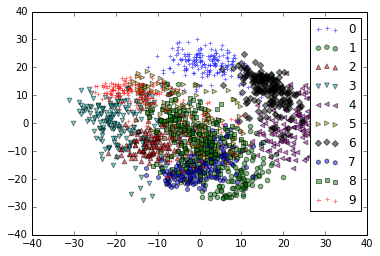

In [123]:
from itertools import cycle  # 將結果輸出成圖表

%matplotlib inline
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
markers = ['+', 'o', '^', 'v', '<', '>', 'D', 'h', 's']
#print y
for i, c, m in zip(np.unique(y), cycle(colors), cycle(markers)):
    plt.scatter(
        X_pca[y == i, 0], 
        X_pca[y == i, 1],
        c=c, 
        marker=m, 
        label=i, 
        alpha=0.5)
plt.legend(loc='best')
plt.show()

In [116]:
from sklearn.svm import SVC       # support vector classification (SVC演算法)
print SVC().fit(X, y).score(X, y) # 用X去training, 然後對y作test, 給出預測正確的比例
                                  # fit是實行訓練, score是計算測試結果
                                  # 結果1.0要注意過度訓練的情形(overfitting)

1.0


In [117]:
from sklearn.cross_validation import train_test_split # 做交叉驗證, 將data分割成train與test兩組
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# test_size=0.2的意思是取20%的資料當成test set

print("train data shape: %r, train target shape: %r" % (X_train.shape, y_train.shape))
print("test data shape: %r, test target shape: %r" % (X_test.shape, y_test.shape))


train data shape: (1437, 64), train target shape: (1437,)
test data shape: (360, 64), test target shape: (360,)


In [118]:
print SVC().fit(X_train, y_train).score(X_train, y_train) # 用訓練組預測自己
                                                          # 當然是會很準...

1.0


In [119]:
SVC().fit(X_train, y_train).score(X_test, y_test) # 用訓練組預測測試組
                                                  # 準度剩下0.325表示overfitting的可能性非常大

0.32500000000000001

SVC 參數預設的值是 C = 100, gamma = 0, 通常這兩個參數會大大影響整體的效果
透過cross validation與Grid找出適合的參數是調校ML的必要工作

In [120]:
from sklearn.cross_validation import ShuffleSplit # 隨機分割組別的套件
cv = ShuffleSplit(n_samples, n_iter=3, test_size=0.1, random_state=0)
# n_iter = 3 表示要產生3組不同的分組方式
# test_size=0.1 表示每組的test set占全部資料的10%

print type(cv)
print len(cv)

<class 'sklearn.cross_validation.ShuffleSplit'>
3


In [148]:
from sklearn.cross_validation import ShuffleSplit
 
cv = ShuffleSplit(n_samples, n_iter=3, test_size=0.1, random_state=1)
 
for cv_index, (train, test) in enumerate(cv):
    print("# Cross Validation Iteration #%d" % cv_index)
    print("train indices: {0}...".format(train[:10])) # 印出前10筆training set的資料
    print("test indices: {0}...".format(test[:10]))   # 印出前10筆test set的資料
     
    svc = SVC(kernel="rbf", C=100, gamma=0.0).fit(X[train], y[train]) # 套用預設值
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
            svc.fit(X[train], y[train]).score(X[train], y[train]), # training set自己預測自己
            svc.fit(X[train], y[train]).score(X[test], y[test])))  # 拿去預測test set

# Cross Validation Iteration #0
train indices: [1533 1473 1102  807 1089 1617  133 1641 1382 1216]...
test indices: [1227 1576  202 1184  428  941  598  267  102 1456]...


/usr/local/python/lib/python2.7/site-packages/sklearn/svm/base.py:85: DeprecationWarning: gamma=0.0 has been deprecated in favor of gamma='auto' as of 0.17. Backward compatibility for gamma=0.0 will be removed in 0.18
  DeprecationWarning)


train score: 1.000, test score: 0.561

# Cross Validation Iteration #1
train indices: [ 458 1273  181  286 1686  442  349  943 1541  811]...
test indices: [1156 1232   93 1220 1060 1491  757  393 1307 1519]...


/usr/local/python/lib/python2.7/site-packages/sklearn/svm/base.py:85: DeprecationWarning: gamma=0.0 has been deprecated in favor of gamma='auto' as of 0.17. Backward compatibility for gamma=0.0 will be removed in 0.18
  DeprecationWarning)


train score: 1.000, test score: 0.594

# Cross Validation Iteration #2
train indices: [ 384 1309  257  410 1664  943 1272 1169  675 1028]...
test indices: [  28 1662  969  407  750  280  758  383  419    4]...


/usr/local/python/lib/python2.7/site-packages/sklearn/svm/base.py:85: DeprecationWarning: gamma=0.0 has been deprecated in favor of gamma='auto' as of 0.17. Backward compatibility for gamma=0.0 will be removed in 0.18
  DeprecationWarning)


train score: 1.000, test score: 0.506



In [149]:
from sklearn.cross_validation import cross_val_score # 用套件分組+跑cv算test score的自動化流程套件
 
cv = ShuffleSplit(n_samples, n_iter=10, test_size=0.1, random_state=0) # 分10組
 
test_scores = cross_val_score(svc, X, y, cv=cv, n_jobs=2) # default svc去計算10組的結果
print test_scores

/usr/local/python/lib/python2.7/site-packages/sklearn/svm/base.py:85: DeprecationWarning: gamma=0.0 has been deprecated in favor of gamma='auto' as of 0.17. Backward compatibility for gamma=0.0 will be removed in 0.18
  DeprecationWarning)
/usr/local/python/lib/python2.7/site-packages/sklearn/svm/base.py:85: DeprecationWarning: gamma=0.0 has been deprecated in favor of gamma='auto' as of 0.17. Backward compatibility for gamma=0.0 will be removed in 0.18
  DeprecationWarning)
/usr/local/python/lib/python2.7/site-packages/sklearn/svm/base.py:85: DeprecationWarning: gamma=0.0 has been deprecated in favor of gamma='auto' as of 0.17. Backward compatibility for gamma=0.0 will be removed in 0.18
  DeprecationWarning)
/usr/local/python/lib/python2.7/site-packages/sklearn/svm/base.py:85: DeprecationWarning: gamma=0.0 has been deprecated in favor of gamma='auto' as of 0.17. Backward compatibility for gamma=0.0 will be removed in 0.18
  DeprecationWarning)
/usr/local/python/lib/python2.7/site-pac

[ 0.41111111  0.57777778  0.58888889  0.52222222  0.48333333  0.61666667
  0.56666667  0.55        0.50555556  0.62777778]


In [150]:
from scipy.stats import sem # 用scipy計算基本統計數據, 統計上面的10筆結果
 
def mean_score(scores):
    """Print the empirical mean score and standard error of the mean."""
    return ("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores))
 # sem(list) list內只能是數值資料, 算出標準差傳回
    
print(mean_score(test_scores)) # 10組test score平均值 加減一個標準差範圍

Mean score: 0.545 (+/-0.021)


使用Grid套件來尋找適合的C與gamma值...

np.logspace(起始值,結束值,sample數,是否包含終點值,底數)

起始值,結束值型態為float, sample數為int,

是否包含終點值為booling, 預設True

底數預設為10.0

In [133]:
from sklearn.grid_search import GridSearchCV
from pprint import pprint

svc_params = {
    'C': np.logspace(-1, 2, 4),
    'gamma': np.logspace(-4, 0, 5),  # 測試範圍(-1~2或-4~0)是作者依照經驗判斷給定的
}
 
n_subsamples = 500
X_small_train, y_small_train = X_train[:n_subsamples], y_train[:n_subsamples] 
# X共有1797組資料, 取0~500資料
 
gs_svc = GridSearchCV(SVC(), svc_params, cv=10, n_jobs=-1)
# cv=10表示作10次分組交叉測試
    
gs_svc.fit(X_small_train, y_small_train) # 加入Grid版本的 SVC().fit()
 
print gs_svc.best_params_, gs_svc.best_score_ # 印出最佳結果, 即可求得最佳的C與gamma值 


{'C': 1.0, 'gamma': 0.001} 0.98


手動做完GridSearchCV作的事情, 用來理解整個求出最佳值的過程:

先固定C值觀察gamma值對score的變化;

接著固定gamma觀察C值對score的變化;

np.zeros((n,m), type) 

(n,m) 這會傳回一個n*m的ndarray, 元素全部都是0

type 用來指定numpy型態,如numpy.int8, 預設是numpy.float64

參考資料
help(np.zeros)

In [136]:
np.zeros((2,3), numpy.int8)

array([[0, 0, 0],
       [0, 0, 0]], dtype=int8)

In [162]:
n_gammas = 10
n_iter = 5
cv = ShuffleSplit(n_samples, n_iter=n_iter, train_size=500, test_size=500, random_state=0)
 
train_scores = np.zeros((n_gammas, n_iter)) # 產生空陣列用來裝值
test_scores = np.zeros((n_gammas, n_iter))
gammas = np.logspace(-7, -1, n_gammas)


for i, gamma in enumerate(gammas):
    for j, (train, test) in enumerate(cv):
        clf = SVC(C=10, gamma=gamma).fit(X[train], y[train]) 
        # SVC().fit() 令C=10,gamma從10**-7~10**-1, 固定C值觀察gamma的變化
        
        train_scores[i, j] = clf.score(X[train], y[train])   # SVC().fit().score()
        test_scores[i, j] = clf.score(X[test], y[test])

5


matplotlib.text(x,y,s,fontdict)

x,y 訂出字串在圖上的座標位置

s 要加到圖上的字串

fontdict 設定字串的格式,可用bbox=dict(facecolor='red', alpha=0.5,fontsize=16)的方式設定

bbox對matplotlib而言是關鍵字

參考資料
help(matplotlib.text)

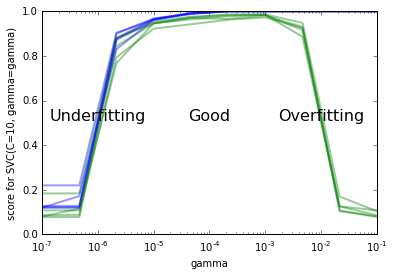

In [143]:
for i in range(n_iter):  # 產生圖表觀察gamma變化
    plt.semilogx(gammas, train_scores[:, i], alpha=0.4, lw=2, c='b') # train是藍線
    plt.semilogx(gammas, test_scores[:, i], alpha=0.4, lw=2, c='g')  # test是綠線
plt.ylabel("score for SVC(C=10, gamma=gamma)")                       # y軸標籤
plt.xlabel("gamma")                                                  # x軸標籤
plt.text(1e-6, 0.5, "Underfitting", fontsize=16, ha='center', va='bottom')
plt.text(1e-4, 0.5, "Good", fontsize=16, ha='center', va='bottom')
plt.text(1e-2, 0.5, "Overfitting", fontsize=16, ha='center', va='bottom')
plt.show()

# 綠線的score越高越好,也就是Good區段的gamma值能得到較高的tes_score, 目測gamma約在10^-3時有最高的score

前面是固定C 觀察gamma

接著固定gamma 觀察C

科學記號:1e-3 = 10^-3 = 0.001; 1e3 = 10^3 = 1000

In [144]:
n_Cs = 10
n_iter = 5
cv = ShuffleSplit(n_samples, n_iter=n_iter, train_size=500, test_size=500,
    random_state=0)
 
train_scores = np.zeros((n_Cs, n_iter))
test_scores = np.zeros((n_Cs, n_iter))
Cs = np.logspace(-5, 5, n_Cs)
 
for i, C in enumerate(Cs):
    for j, (train, test) in enumerate(cv):
        clf = SVC(C=C, gamma=1e-3).fit(X[train], y[train])
        # SVC().fit() 令gamma=1*0.001, 觀察C從10**-5~10**5
        
        train_scores[i, j] = clf.score(X[train], y[train])
        test_scores[i, j] = clf.score(X[test], y[test])


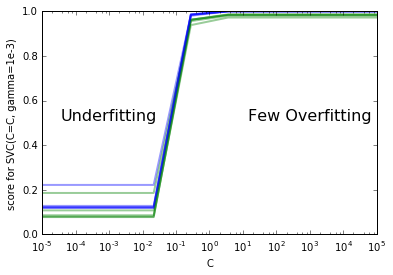

In [146]:
for i in range(n_iter):
    plt.semilogx(Cs, train_scores[:, i], alpha=0.4, lw=2, c='b')
    plt.semilogx(Cs, test_scores[:, i], alpha=0.4, lw=2, c='g')
plt.ylabel("score for SVC(C=C, gamma=1e-3)")
plt.xlabel("C")
plt.text(1e-3, 0.5, "Underfitting", fontsize=16, ha='center', va='bottom')
plt.text(1e3, 0.5, "Few Overfitting", fontsize=16, ha='center', va='bottom')
plt.show()

# 同樣是綠線的score越高越好, 目測C在10^1~10^2就達到score=1.0

綜合兩張圖的結論, gamma在10^-3且C在10^1~10^2最好

與GridSearchCV算出的結論{'C': 1.0, 'gamma': 0.001}相近

In [147]:
svc_2 = SVC(kernel='rbf', C=10, gamma=0.001).fit(X_train, y_train) # 將GridSearchCV算出的結果代入SVC
train_score = svc_2.score(X_train, y_train) 
print train_score
 
test_score = svc_2.score(X_test, y_test)
print test_score

# test_score = 0.99166...

1.0
0.991666666667


KFold(資料數量,K次,shuffle,random_state)

SVC(C,kernel,gamma)

kernel有linear, poly, rbf, sigmoid, precomputed這幾種可選,
也可放入自定義的陣列(n_samples, n_samples)

參考資料:help(SVC)

In [163]:
from sklearn.cross_validation import KFold          # KFold
from sklearn.datasets import load_digits            # sklearn內建的資料庫

digits = load_digits()
X,y = digits.data, digits.target                    # X是帶有答案(標籤,或特徵)的資料; y只有data
kf = KFold(1797,n_folds=10,shuffle=True,random_state=0)
#for train_index, test_index in kf:
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]

n_iter = 10
train_scores = np.zeros((n_gammas, n_iter))         # 產生空陣列用來裝值
test_scores = np.zeros((n_gammas, n_iter))
gammas = np.logspace(-7, -1, n_gammas)

for i, gamma in enumerate(gammas):
    for j, (train_index, test_index) in enumerate(kf):
        kf_svc = SVC(kernel='rbf', C=10, gamma=gamma).fit(X[train_index], y[train_index]) 
        # SVC().fit() 令C=10,gamma從10**-7~10**-1, 固定C值觀察gamma的變化
        # kernel = "rbf"
        
        train_scores[i,j] = kf_svc.score(X[train_index], y[train_index])  # SVC().fit().score()
        test_scores[i,j] = kf_svc.score(X[test_index], y[test_index])

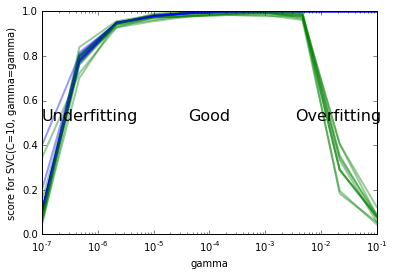

In [174]:
# kernel="rbf", gamma=10**-7~10**-1
for i in range(n_iter):  # 產生圖表觀察gamma變化
    plt.semilogx(gammas, train_scores[:, i], alpha=0.4, lw=2, c='b') # train是藍線
    plt.semilogx(gammas, test_scores[:, i], alpha=0.4, lw=2, c='g')  # test是綠線
plt.ylabel("score for SVC(C=10, gamma=gamma)")                       # y軸標籤
plt.xlabel("gamma")                                                  # x軸標籤
plt.text(1e-7, 0.5, "Underfitting", fontsize=16, ha='left', va='bottom')
plt.text(1e-4, 0.5, "Good", fontsize=16, ha='center', va='bottom')
plt.text(2e-2, 0.5, "Overfitting", fontsize=16, ha='center', va='bottom')
plt.show()

# 目測gamma約在10^-4~10^-3時有最高的score

In [175]:
from sklearn.cross_validation import KFold          # KFold
from sklearn.datasets import load_digits            # sklearn內建的資料庫

digits = load_digits()
X,y = digits.data, digits.target                    # X是帶有答案(標籤,或特徵)的資料; y只有data
kf = KFold(1797,n_folds=10,shuffle=True,random_state=0)

n_iter = 10
train_scores = np.zeros((n_gammas, n_iter))         # 產生空陣列用來裝值
test_scores = np.zeros((n_gammas, n_iter))
gammas = np.logspace(-7, -1, n_gammas)

for i, gamma in enumerate(gammas):
    for j, (train_index, test_index) in enumerate(kf):
        kf_svc = SVC(kernel='linear', C=10, gamma=gamma).fit(X[train_index], y[train_index]) 
        # SVC().fit() 令C=10,gamma從10**-7~10**-1, 固定C值觀察gamma的變化
        # kernel='linear'
        
        train_scores[i,j] = kf_svc.score(X[train_index], y[train_index])  # SVC().fit().score()
        test_scores[i,j] = kf_svc.score(X[test_index], y[test_index])

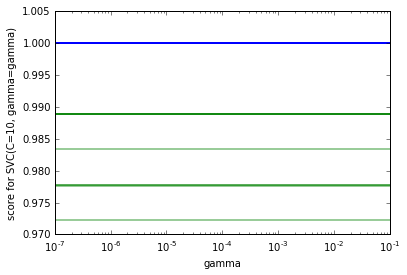

In [177]:
# kernel="linear", gamma=10**-7~10**-1
for i in range(n_iter):  # 產生圖表觀察gamma變化
    plt.semilogx(gammas, train_scores[:, i], alpha=0.4, lw=2, c='b') # train是藍線
    plt.semilogx(gammas, test_scores[:, i], alpha=0.4, lw=2, c='g')  # test是綠線
plt.ylabel("score for SVC(C=10, gamma=gamma)")                       # y軸標籤
plt.xlabel("gamma")                                                  # x軸標籤
plt.show()

# linear就是線性, 線性就是...

In [178]:
digits = load_digits()
X,y = digits.data, digits.target                    # X是帶有答案(標籤,或特徵)的資料; y只有data
kf = KFold(1797,n_folds=10,shuffle=True,random_state=0)

n_iter = 10
train_scores = np.zeros((n_gammas, n_iter))         # 產生空陣列用來裝值
test_scores = np.zeros((n_gammas, n_iter))
gammas = np.logspace(-7, -1, n_gammas)

for i, gamma in enumerate(gammas):
    for j, (train_index, test_index) in enumerate(kf):
        kf_svc = SVC(kernel='poly', C=10, gamma=gamma).fit(X[train_index], y[train_index]) 
        # SVC().fit() 令C=10,gamma從10**-7~10**-1, 固定C值觀察gamma的變化
        # kernel='poly'
        
        train_scores[i,j] = kf_svc.score(X[train_index], y[train_index])  # SVC().fit().score()
        test_scores[i,j] = kf_svc.score(X[test_index], y[test_index])

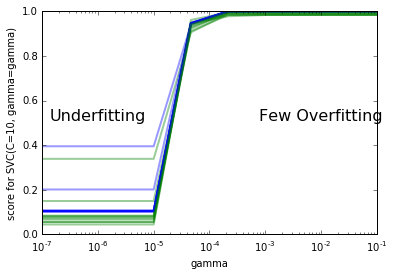

In [183]:
# kernel="poly", gamma=10**-7~10**-1
for i in range(n_iter):  # 產生圖表觀察gamma變化
    plt.semilogx(gammas, train_scores[:, i], alpha=0.4, lw=2, c='b') # train是藍線
    plt.semilogx(gammas, test_scores[:, i], alpha=0.4, lw=2, c='g')  # test是綠線
plt.ylabel("score for SVC(C=10, gamma=gamma)")                       # y軸標籤
plt.xlabel("gamma")                                                  # x軸標籤
plt.text(1e-6, 0.5, "Underfitting", fontsize=16, ha='center', va='bottom')
plt.text(1e-2, 0.5, "Few Overfitting", fontsize=16, ha='center', va='bottom')
plt.show()

# 目測gamma約在10^-4~10^-3時有最高的score

In [184]:
digits = load_digits()
X,y = digits.data, digits.target                    # X是帶有答案(標籤,或特徵)的資料; y只有data
kf = KFold(1797,n_folds=10,shuffle=True,random_state=0)

n_iter = 10
train_scores = np.zeros((n_gammas, n_iter))         # 產生空陣列用來裝值
test_scores = np.zeros((n_gammas, n_iter))
gammas = np.logspace(-7, -1, n_gammas)

for i, gamma in enumerate(gammas):
    for j, (train_index, test_index) in enumerate(kf):
        kf_svc = SVC(kernel='sigmoid', C=10, gamma=gamma).fit(X[train_index], y[train_index]) 
        # SVC().fit() 令C=10,gamma從10**-7~10**-1, 固定C值觀察gamma的變化
        # kernel='sigmoid'
        
        train_scores[i,j] = kf_svc.score(X[train_index], y[train_index])  # SVC().fit().score()
        test_scores[i,j] = kf_svc.score(X[test_index], y[test_index])

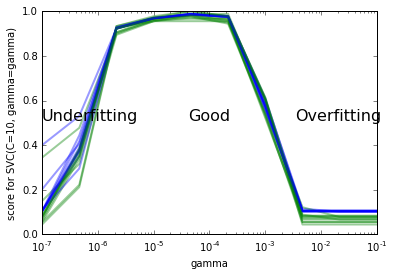

In [186]:
# kernel="sigmoid", gamma=10**-7~10**-1
for i in range(n_iter):  # 產生圖表觀察gamma變化
    plt.semilogx(gammas, train_scores[:, i], alpha=0.4, lw=2, c='b') # train是藍線
    plt.semilogx(gammas, test_scores[:, i], alpha=0.4, lw=2, c='g')  # test是綠線
plt.ylabel("score for SVC(C=10, gamma=gamma)")                       # y軸標籤
plt.xlabel("gamma")                                                  # x軸標籤
plt.text(1e-7, 0.5, "Underfitting", fontsize=16, ha='left', va='bottom')
plt.text(1e-4, 0.5, "Good", fontsize=16, ha='center', va='bottom')
plt.text(2e-2, 0.5, "Overfitting", fontsize=16, ha='center', va='bottom')
plt.show()

# 目測gamma約在10^-4時有最高的score

In [192]:
from sklearn.svm import SVR # SVM-regression

digits = load_digits()
X,y = digits.data, digits.target                    # X是帶有答案(標籤,或特徵)的資料; y只有data
kf = KFold(1797,n_folds=10,shuffle=True,random_state=0)

n_iter = 10
train_scores = np.zeros((n_gammas, n_iter))         # 產生空陣列用來裝值
test_scores = np.zeros((n_gammas, n_iter))
gammas = np.logspace(-7, -1, n_gammas)

for i, gamma in enumerate(gammas):
    for j, (train_index, test_index) in enumerate(kf):
        kf_svc = SVR(kernel='rbf', C=10, gamma=gamma).fit(X[train_index], y[train_index]) 
        # SVR().fit() 令C=10,gamma從10**-7~10**-1, 固定C值觀察gamma的變化
        # kernel='rbf'
        
        train_scores[i,j] = kf_svc.score(X[train_index], y[train_index])
        test_scores[i,j] = kf_svc.score(X[test_index], y[test_index])

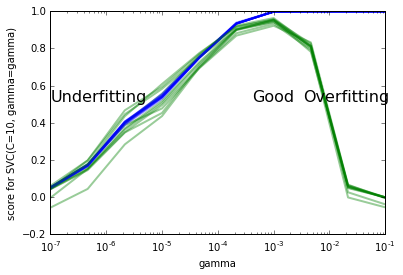

In [194]:
#SVR, kernel="rbf", gamma=10**-7~10**-1
for i in range(n_iter):  # 產生圖表觀察gamma變化
    plt.semilogx(gammas, train_scores[:, i], alpha=0.4, lw=2, c='b') # train是藍線
    plt.semilogx(gammas, test_scores[:, i], alpha=0.4, lw=2, c='g')  # test是綠線
plt.ylabel("score for SVC(C=10, gamma=gamma)")                       # y軸標籤
plt.xlabel("gamma")                                                  # x軸標籤
plt.text(1e-7, 0.5, "Underfitting", fontsize=16, ha='left', va='bottom')
plt.text(1e-3, 0.5, "Good", fontsize=16, ha='center', va='bottom')
plt.text(2e-2, 0.5, "Overfitting", fontsize=16, ha='center', va='bottom')
plt.show()

# 目測gamma約在10^-3時有最高的score

In [188]:
help(SVC)

Help on class SVC in module sklearn.svm.classes:

class SVC(sklearn.svm.base.BaseSVC)
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to dataset with more than a couple of 10000 samples.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  other, see the corresponding section in the narrative documentation:
 |  :ref:`svm_kernels`.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  C : float, optional (default=1.0)
 |      Penalty parameter C of the error term.
 |  
 |  kernel : string, optional (default='rbf')
 |       Specifies the kernel type to be used in the algorithm.
 |       It must be one of 'linear', 'poly

In [191]:
help(SVR)

Help on class SVR in module sklearn.svm.classes:

class SVR(sklearn.svm.base.BaseLibSVM, sklearn.base.RegressorMixin)
 |  Epsilon-Support Vector Regression.
 |  
 |  The free parameters in the model are C and epsilon.
 |  
 |  The implementation is based on libsvm.
 |  
 |  Read more in the :ref:`User Guide <svm_regression>`.
 |  
 |  Parameters
 |  ----------
 |  C : float, optional (default=1.0)
 |      Penalty parameter C of the error term.
 |  
 |  epsilon : float, optional (default=0.1)
 |       Epsilon in the epsilon-SVR model. It specifies the epsilon-tube
 |       within which no penalty is associated in the training loss function
 |       with points predicted within a distance epsilon from the actual
 |       value.
 |  
 |  kernel : string, optional (default='rbf')
 |       Specifies the kernel type to be used in the algorithm.
 |       It must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or
 |       a callable.
 |       If none is given, 'rbf' will be used. I

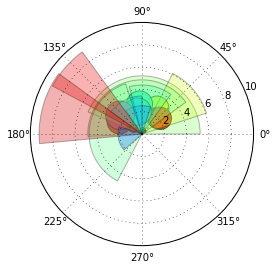

In [115]:
"""
Demo of scatter plot on a polar axis.

Size increases radially in this example and color increases with angle (just to
verify the symbols are being scattered correctly).
"""

# 模擬風暴圖呈現, 與ML無關
import numpy as np
import matplotlib.pyplot as plt

plt.subplot(1,1,1)
####扇形設定
N = 10
theta = np.linspace(0.0, 1 * np.pi, N, endpoint=False)
radii = 10 * np.random.rand(N)
width = np.pi / 1 * np.random.rand(N)

ax = plt.subplot(111, projection='polar')
bars = ax.bar(theta, radii, width=width, bottom=0.0)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.3)
####點設定
N = 10
r = 3 * np.random.rand(N)
theta = 1 * np.pi * np.random.rand(N)
area = 200 * r**2 * np.random.rand(N)
colors = theta

ax = plt.subplot(111, projection='polar')
c = plt.scatter(theta, r, c=colors, s=area, cmap=plt.cm.hsv)
c.set_alpha(0.9)

plt.show()